# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat  PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import scipy.optimize as opt
import scipy.stats as stats

In [51]:
d1=pd.read_csv('PS1_PS1MD_PSc000098.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')
d1g = d1.query('FLT == "g"')
d2=pd.read_csv('PS1_PS1MD_PSc000174.snana.dat',header=14,sep='\s+',skipfooter=1,engine='python')

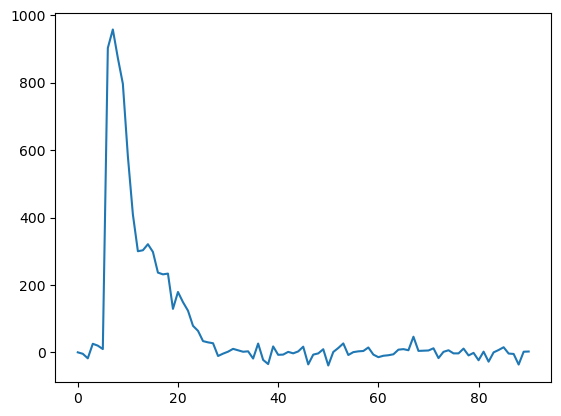

In [22]:
plt.plot(d1.query('FLT == "g"').FLUXCAL);

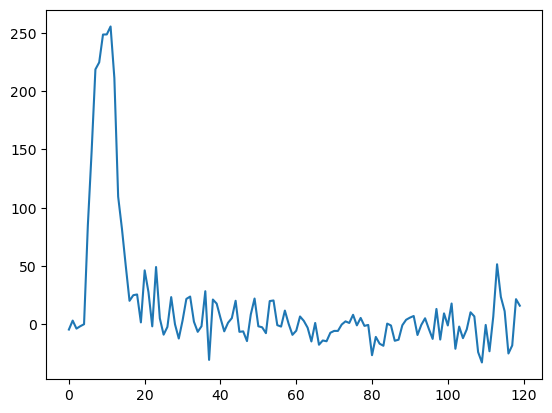

In [20]:
plt.plot(d2.query('FLT == "g"').FLUXCAL);

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

She used equation 1, defined here: https://arxiv.org/abs/1905.07422

$$\Large F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $$

In [29]:
d1.columns

Index(['VARLIST:', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG',
       'MAGERR'],
      dtype='object')

In [206]:
# def fmod(t,A,b,tr,tf,t0,t1):
#     if t < t1:
#         ug1= A+b*(t-t0)
#         ug2=1+np.exp(-(t-t0)/tr)
        
#     elif t >= t1:
#         ug1 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
#         ug2 = 1+np.exp((-t-t0)/tr)
#     else:
#         ug1=-np.inf
#         ug2=np.inf
#     return ug1/ug2

def fmod(t,A,b,tr,tf,t0,t1):
    fluxa = np.zeros_like(t)
    mask = t<t1
    ug1= A+b*(t-t0)
    ug2=1+np.exp(-(t-t0)/tr)
    fluxa[mask] = (ug1/ug2)[mask]
    ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
    ug4 = 1+np.exp((-t-t0)/tr)
    fluxa[~mask] = (ug3/ug4)[~mask]
    return np.nan_to_num(fluxa)

In [172]:
a=b=np.arange(10)
np.piecewise(a,[b<5,b>=5],[1,0])*a

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 0])

In [ ]:
np.nan

In [173]:
te=np.arange(10)
te[te<5]
te*(te<5)

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 0])

```python
# we'll define a (reduced) chisq function for convenience
def chisq(x, *args):
    I_0, p, tmax, tE = x
    t, y, dy = args
    mod = logmodel(I_0, p, tmax, tE, t)
    chisq = np.sum(((y - mod)**2.)/(dy**2. + unoise**2.))/(len(t) -4)
    return chisq 
```

In [175]:
def loss(vl,data):
    og=(data.FLUXCAL.values-fmod(data.MJD.values,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))**2/(2*data.FLUXCALERR.values)**2
    return np.sum(og)
def LogLike(A,b,tr,tf,t0,t1,data):
    args = (A,b,tr,tf,t0,t1)
    return -loss(args,data)

In [295]:
args = [900,1,10,30,55200,55250]
ex=opt.minimize(loss,args,args=(d1g)).x

/tmp/ipykernel_11002/3091995729.py:18: RuntimeWarning: overflow encountered in exp
  ug2=1+np.exp(-(t-t0)/tr)
/tmp/ipykernel_11002/3091995729.py:21: RuntimeWarning: overflow encountered in exp
  ug4 = 1+np.exp((-t-t0)/tr)
/tmp/ipykernel_11002/3091995729.py:18: RuntimeWarning: overflow encountered in exp
  ug2=1+np.exp(-(t-t0)/tr)
/tmp/ipykernel_11002/3091995729.py:21: RuntimeWarning: overflow encountered in exp
  ug4 = 1+np.exp((-t-t0)/tr)


/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


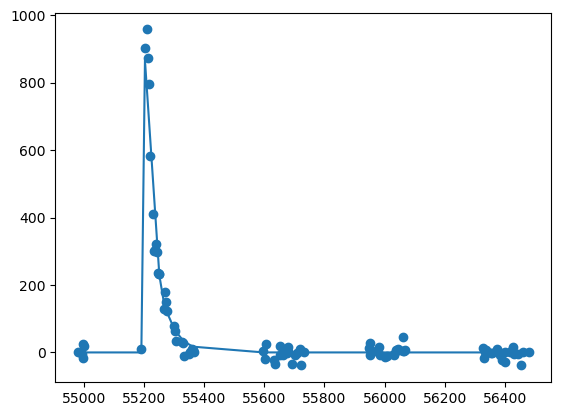

In [296]:
plt.scatter(d1g.MJD,d1g.FLUXCAL)
#A,b,tr,tf,t0,t1
args = [1000,1,10,30,55200,55250]
plt.plot(d1g.MJD,fmod(d1g.MJD,*ex))

```python
def LogPrior(I_0, p, tmax, tE):
    
    # we can put some big bounds on the parameters
    if (I_0 >= 18  or I_0 <= 15) or\
        (p <= 0 or p >= 3)  or\
        (tE <= 10 or tE > 70) or\
        (tmax <= 2458400 or tmax >= 2458600):   
        return -np.inf
    
    # we can also make the priors non-trivial
    # but we also know we want the priors to be somewhat uninformative
    # the data should determine the model parameters, not the prior
    # so I'll make the widths very wide
    p_I0 = st.norm.pdf(I_0, loc=1.72653507e+01, scale=1.)
    p_p = st.norm.pdf(p, loc=6.87406601e-01, scale=1.)
    p_tmax = st.norm.pdf(tmax, loc=2.45852788e+06, scale=10.)
    p_tE = st.norm.pdf(tE, loc=2.54557543e+01, scale=10.)
    prior = p_I0*p_p*p_tmax*p_tE
    
    lnprior = np.log(prior)
    return lnprior
```

|Parameter| Description| Prior |
|--------:|-----------:|:------|
|τrise (days) |Rise Time |U(0.01,50)|
|τfall (days) |Decline Time| U(1,300)|
|t0 (MJD) |“Start” Time| U(tmin − 50, tmax + 300)|
|A| Amplitude| U(3σ,100 Fmax)|
|β (flux/day)| Plateau slope| U(−Fmax/150,0)|
|c (flux) |Baseline Flux| U(−3σ,3σ)|
|γ (days) |Plateau duration|(2/3)N(5, 5) + (1/3) N(60, 30) |

In [142]:
def LogPrior(A,b,tr,tf,t0,t1,data):
    # bounds go here
    
    p_A =stats.uniform.pdf(A,0.01,50)
    p_b = stats.uniform.pdf(b)
    p_tr = stats.uniform.pdf(tr)
    p_tf = stats.uniform.pdf(tf,1,300)
    p_t0 = stats.uniform.pdf(t0)
    p_t1 = stats.uniform.pdf(t1)
    prior = p_A*p_b*p_tr*p_tf*p_t0*p_t1
    lnprior = np.log(prior)
    return lnprior

```python
def LogPosterior(params, t=None, y=None, dy=None):
    I_0, p, tmax, tE = params
    lnlike = LogLikelihood(I_0, p, tmax, tE, t, y, dy)
    lnprior = LogPrior(I_0, p, tmax, tE)
    lnposterior = lnlike + lnprior
    return lnposterior
```

In [59]:
def LogPosterior(params,data):
    A,b,tr,tf,t0,t1 = params
    lnlike = LogLike(*params,data)
    lnprior = LogPrior(*params,data)
    return lnprior+lnlike

In [42]:
ndim=6
nwalkers=20
np.random.seed(10)
# starting_guesses = np.zeros((nwalkers, ndim))
# starting_guesses[:, 2] = np.random.uniform(0.01, 1, (nwalkers, 1))
# starting_guesses[:,0] = np.random.uniform((nwalkers,1))
# starting_guesses = np.random.uniform(size=(nwalkers,ndim))
# starting_guesses;

In [208]:
p0  = np.random.uniform(size=(nwalkers,ndim))
kwargs = {'data':d1g}
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs=kwargs )
sampler.run_mcmc(p0, 1000,progress=True)

/tmp/ipykernel_11002/3337866580.py:11: RuntimeWarning: divide by zero encountered in log
  lnprior = np.log(prior)
You must install the tqdm library to use progress indicators with emcee
/tmp/ipykernel_11002/3091995729.py:20: RuntimeWarning: overflow encountered in exp
  ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
/tmp/ipykernel_11002/3618467147.py:2: RuntimeWarning: overflow encountered in square
  og=(data.FLUXCAL.values-fmod(data.MJD.values,vl[0],vl[1],vl[2],vl[3],vl[4],vl[5]))**2/(2*data.FLUXCALERR.values)**2
/tmp/ipykernel_11002/3091995729.py:18: RuntimeWarning: overflow encountered in exp
  ug2=1+np.exp(-(t-t0)/tr)
/tmp/ipykernel_11002/3091995729.py:21: RuntimeWarning: overflow encountered in exp
  ug4 = 1+np.exp((-t-t0)/tr)
/tmp/ipykernel_11002/3091995729.py:22: RuntimeWarning: invalid value encountered in divide
  fluxa[~mask] = (ug3/ug4)[~mask]
/home/berres2002/miniconda3/envs/fds/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in 

State([[2.85833982e+01 9.21207435e-02 6.62293882e-01 1.41925734e+01
  4.15946501e-01 9.83676024e-01]
 [4.16577354e+01 8.94759387e-01 8.91032705e-02 7.70585647e+01
  1.94539376e-01 9.03571034e-01]
 [4.16381450e+01 2.76803050e-01 5.95035340e-01 2.72290068e+01
  1.79284414e-01 5.57323364e-01]
 [1.42894289e+01 8.84746597e-01 8.41226335e-01 8.11420233e+00
  4.26274390e-01 1.57850817e-02]
 [4.63235901e+01 5.94389520e-01 2.19658002e-01 7.83934923e+01
  9.26889944e-01 3.81715788e-02]
 [1.84865335e+01 3.34371325e-01 3.13676514e-02 7.69201195e+01
  2.48926130e-01 3.34910610e-01]
 [3.52351387e+01 1.68136876e-01 2.53251289e-01 2.88334693e+01
  8.56303754e-01 4.63494922e-01]
 [3.07161448e+01 5.57575425e-01 3.93703717e-01 1.17812061e+00
  1.64229447e-01 3.08863164e-01]
 [1.57352831e+01 4.56312130e-02 5.71965449e-01 1.35939280e+01
  2.40916342e-01 2.00193115e-01]
 [3.14932352e+01 2.20182355e-01 3.57187365e-01 5.31138219e+01
  2.85939685e-02 6.44437190e-01]
 [4.99442382e+01 7.17118338e-01 6.73829718e-

In [74]:
sam=sampler.get_chain(flat=True)
sam.shape

(20000, 6)

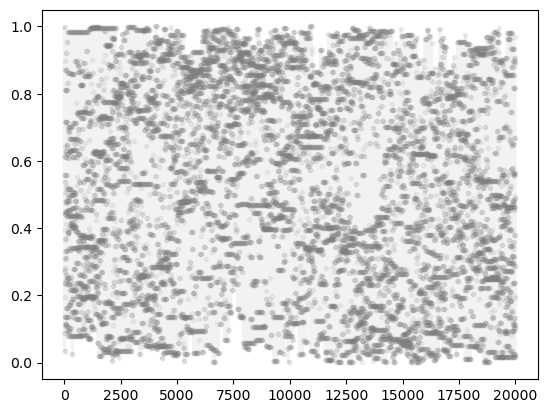

In [101]:
plt.plot(sam[:,4], linestyle='-', color='grey', marker='.', alpha=0.1)

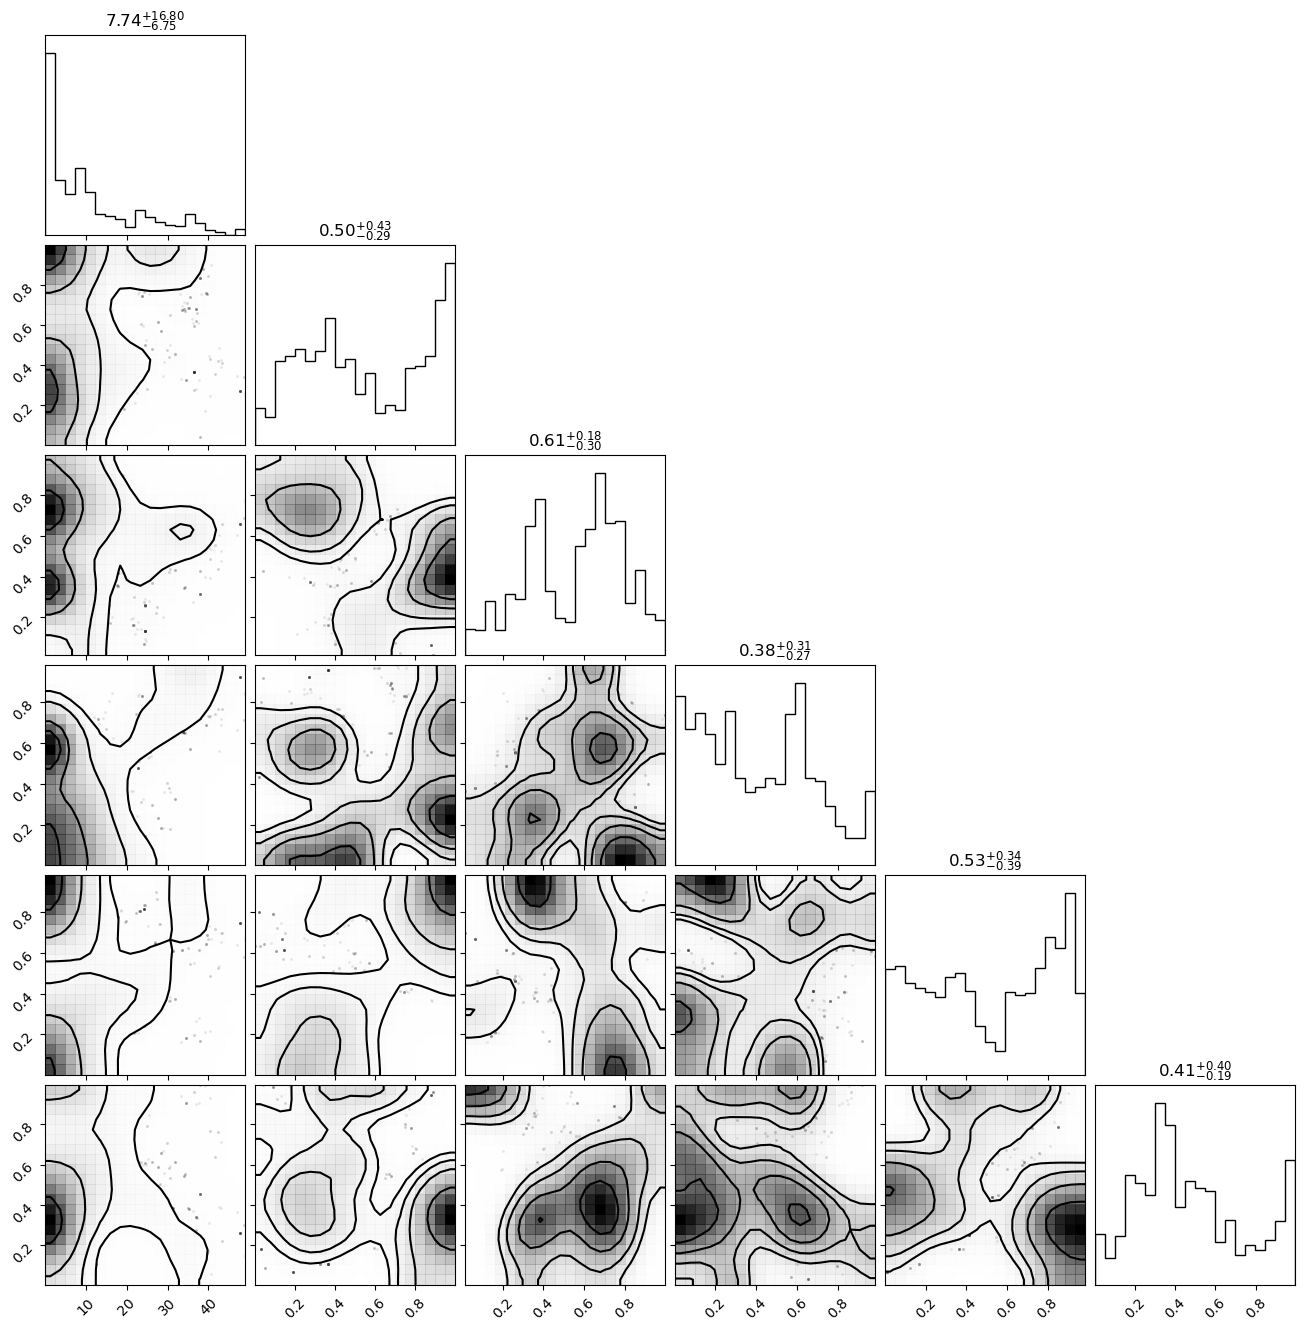

In [209]:
fig = corner.corner(sam[1000::10,:], plot_contours=True, show_titles=True, smooth=2)

In [212]:
mcmc_res = np.percentile(sam, [50, 16, 84], axis=0)


In [211]:
mcmc_res[0]
fmod(d1g.MJD.values,7.65674007, 0.61936385, 0.5359665 , 0.48217232, 0.52508233,0.59079379)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [ ]:
loss()

In [ ]:
LogLike()

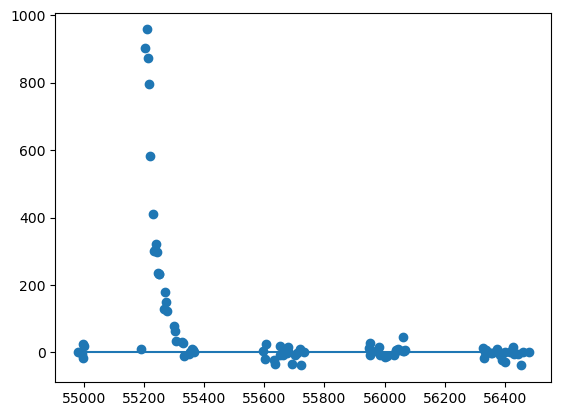

In [213]:
plt.scatter(d1g.MJD,d1g.FLUXCAL)
plt.plot(d1g.MJD,fmod(d1g.MJD,*mcmc_res[0]))

In [141]:
fmod(d1g.MJD,*mcmc_res[0])

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
86    0.0
87    0.0
88    0.0
89    0.0
90    0.0
Name: MJD, Length: 91, dtype: float64

In [90]:
sam

array([[8.74930525e-02, 1.16879440e-01, 7.71071255e-01, 7.32795269e-01,
        8.71283569e-02, 3.57463198e-01],
       [7.73211622e-01, 1.31471602e-01, 5.37832434e-01, 7.54723566e-01,
        2.72526176e-01, 5.66516996e-01],
       [5.64092846e-01, 4.24596096e-01, 4.39605847e-01, 9.35130956e-01,
        9.98120416e-01, 7.37143551e-01],
       ...,
       [9.80784935e+00, 3.18566697e-01, 8.96814091e-02, 1.78458538e-01,
        1.67086051e-02, 2.02139366e-01],
       [3.96780589e+01, 2.92349109e-01, 5.91162380e-01, 9.62315334e-01,
        4.94805052e-01, 8.61960031e-01],
       [3.41967361e+01, 9.59505928e-01, 8.81993594e-01, 1.95024700e-01,
        4.61777096e-01, 7.26442521e-01]])

In [203]:
fmod(d1g.MJD.values,*[1,1,1,1,1,54995])

array([5.49804000e+004, 5.49933000e+004, 1.49878860e+004, 7.46202903e+002,
       3.71512549e+001, 2.28048943e-081, 1.40118113e-086, 3.47318079e-089,
       1.72919489e-090, 8.60915444e-092, 2.13399603e-094, 2.63356032e-098,
       1.44906969e-099, 6.52794337e-101, 3.59188465e-102, 1.78829407e-103,
       4.43273781e-106, 2.20693020e-107, 2.20693020e-107, 6.75105070e-114,
       3.04129449e-115, 1.51417137e-116, 8.33145845e-118, 5.19904288e-129,
       1.73061104e-129, 9.52237920e-131, 6.53328951e-140, 3.25273332e-141,
       1.78975861e-142, 2.72579874e-150, 1.35709528e-151, 3.36390288e-154,
       1.67478863e-155, 8.33828159e-157, 2.94281454e-257, 8.06167805e-260,
       3.63172166e-261, 6.82592551e-273, 3.75584402e-274, 1.03958707e-280,
       5.72014283e-282, 7.80164140e-286, 4.29271431e-287, 5.29763033e-291,
       2.38654021e-292, 1.31315127e-293, 7.30048187e-299, 9.95704886e-303,
       1.22879745e-306, 1.51645652e-310, 7.54999256e-312, 9.31698397e-316,
       0.00000000e+000, 0

In [105]:
np.ones(6)

array([1., 1., 1., 1., 1., 1.])

In [137]:
def fmod1(t,A,b,tr,tf,t0,t1):
    mask = t<t1
    ug1= A+b*(t-t0)
    ug2=1+np.exp(-(t-t0)/tr)
    uga = (ug1/ug2)*(mask)
    ug3 = (A+b*(t1-t0))*np.exp(-(t-t1)/tf)
    ug4 = 1+np.exp((-t-t0)/tr)
    ugb = (ug3/ug4)*(~mask)
    return uga

In [112]:
d1g.MJD

0     54980.4
1     54993.3
2     54996.3
3     54999.3
4     55002.3
       ...   
86    56430.4
87    56443.3
88    56451.3
89    56460.3
90    56478.3
Name: MJD, Length: 91, dtype: float64